# LangGraph Router - Python Cookbook

### llm setup for LangChain

In [1]:
from dotenv import load_dotenv
from langchain_google_genai import ChatGoogleGenerativeAI
load_dotenv()

llm = ChatGoogleGenerativeAI(model='gemini-2.5-flash',temperature=0)


### tools

In [2]:
from langchain_core.tools import tool
from langchain_tavily import TavilySearch

@tool
def get_weather(city: str, unit: str = 'celsius') -> str:
	"""Get the weather for a city."""
	return f"The weather in {city} is 25 degrees {unit}."

@tool
def web_search(query: str) -> str:
	"""Search the web for a query."""
	tavily_search_tool = TavilySearch(
		max_results=5,
		topic="general",
	)
	return tavily_search_tool.invoke(query)

TOOL_MAP = {
	"get_weather": get_weather,
	"web_search": web_search,
}

### Add tools to the llm

In [3]:
llm = llm.bind_tools([get_weather, web_search])

### State - Message from Langchain

### Reducers

##### What? - Reducers are functions to apply updates from nodes to state

In [4]:
from typing import Annotated, TypedDict
from langchain_core.messages import AnyMessage, HumanMessage, AIMessage

from langgraph.graph.message import add_messages # add_messages is the reducer to add messages to the state

class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

In [5]:
# BTS of add_messages - reference: https://github.com/langchain-ai/langchain-academy/blob/main/module-1/chain.ipynb 

initial_messages = [AIMessage(content="Hello! How can I assist you?", name="Model"),
                    HumanMessage(content="I'm looking for information on marine biology.", name="Lance")
                   ]

# New message to add
new_message = AIMessage(content="Sure, I can help with that. What specifically are you interested in?", name="Model")

# Test
add_messages(initial_messages , new_message)

[AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, name='Model', id='8d404f27-6ea1-4779-ab07-c9cd7914931f'),
 HumanMessage(content="I'm looking for information on marine biology.", additional_kwargs={}, response_metadata={}, name='Lance', id='4124ace2-92d1-408b-9fed-80e30e0aaa24'),
 AIMessage(content='Sure, I can help with that. What specifically are you interested in?', additional_kwargs={}, response_metadata={}, name='Model', id='e6e96af2-08cf-4ccb-bb1a-9f99af07489a')]

### Node

In [6]:
from langchain_core.messages import ToolMessage

def triage_node(state: MessagesState):
	llm_output = llm.invoke(state["messages"])
	
	updated_messages = state["messages"] + [llm_output]
	
	for tool_call in llm_output.tool_calls:
		tool = TOOL_MAP[tool_call["name"]]
		tool_output = tool.invoke(tool_call["args"])
		
		tool_message = ToolMessage(
			content=str(tool_output),
			tool_call_id=tool_call["id"]
		)
		updated_messages.append(tool_message)
	
	return {"messages": updated_messages}

### Build Graph

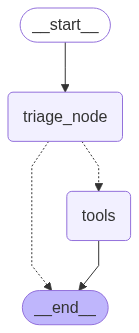

In [9]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition


builder = StateGraph(MessagesState)
builder.add_node("triage_node", triage_node)
builder.add_node("tools", ToolNode([get_weather, web_search]))
builder.add_edge(START, "triage_node")
builder.add_conditional_edges(
	"triage_node",
	tools_condition
)
builder.add_edge("tools", END)
graph = builder.compile()


display(Image(graph.get_graph().draw_mermaid_png()))

### Invoke Graph

#### a. simple message - requring no tools

In [ ]:
messages = graph.invoke({"messages": [HumanMessage(content="What up!")]})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

What up!
================================== Ai Message ==================================

Hello! How can I help you today?


#### b. tool calling - with weather tool

In [ ]:
messages = graph.invoke({"messages": [HumanMessage(content="What is the weather in San Francisco?")]})
for m in messages['messages']:
	m.pretty_print()

================================ Human Message =================================

What is the weather in San Francisco?
================================== Ai Message ==================================
Tool Calls:
  get_weather (a8cc8d36-d4dd-493b-b557-63851a363580)
 Call ID: a8cc8d36-d4dd-493b-b557-63851a363580
  Args:
    city: San Francisco
================================= Tool Message =================================

The weather in San Francisco is 25 degrees celsius.


#### c. tool calling - with web_search tool

In [10]:
messages = graph.invoke({"messages": [HumanMessage(content="What is the current news in NY?")]})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

What is the current news in NY?
================================== Ai Message ==================================
Tool Calls:
  web_search (b4138948-7ae4-4a8b-b22c-7b128194b1e5)
 Call ID: b4138948-7ae4-4a8b-b22c-7b128194b1e5
  Args:
    query: current news in NY
================================= Tool Message =================================

{'query': 'current news in NY', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'url': 'https://www.nbcnewyork.com/', 'title': 'NBC 4 New York – NY local news, breaking news, weather', 'content': 'Manhattan 3 hours ago. 2 women arrested in deadly Chinatown mow down of cyclist, woman on sidewalk · news 10 hours ago. Trump says releasing Epstein files wouldn', 'score': 0.57064295, 'raw_content': None}, {'url': 'https://www.fox5ny.com/', 'title': 'FOX 5 New York | Local News, Weather, and Live Streams | WNYW', 'content': 'All Latest Headlines · At